<a href="https://colab.research.google.com/github/Theano2247/NFTs/blob/main/Solana_NFTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLANA NFTs

*   The **objective** of this project is to **consolidate historical data** of SOLANA NFT projects and **visualize them in one place** for *ease of comparison*.

*   This job is necessary because no NFT marketplaces/websites graphs different projects together - they only show one graph per project in the analytics section, which makes it impossible to visually grasp the overall price/holder trends of NFT projects.

*   Also needed to make a custom database for holder statistics because historical stats are not available.




# Prices


## Price Data Collection


**This section will only work for authenticated user -- please proceed to Price Data Processing**




In [ ]:
# List of current projects on bucket
symbols = ['abc_abracadabra',
 'assetdash_vanta',
 'blocksmith_labs',
 'bodoggos',
 'cets_on_creck',
 'claynosaurz',
 'degenerate_ape_academy',
 'degenfatcats',
 'famous_fox_federation',
 'ghost_kid_dao',
 'lily',
 'mad_lads',
 'meegos',
 'okay_bears',
 'primates',
 'rascals',
 'sharx',
 'smb_gen3',
 'sodead',
 'solana_monkey_business',
 'solcasino',
 'taiyo_robotics',
 'transdimensional_fox_federation',
 'wolf_capital']

In [ ]:
# Connect to google cloud
from google.colab import auth
auth.authenticate_user()

project_id = 'solana-nft-db'

In [ ]:
# Collect proejct timeseries data from magiceden
files = []
for k in symbols:
  response = requests.get("https://stats-mainnet.magiceden.io/collection_stats/getCollectionTimeSeries/{}?edge_cache=true&resolution=6h&addLastDatum=true".format(k))
  data = json.loads(response.text)
  with open('{}.json'.format(k), 'w') as json_file:
    json.dump(data, json_file)
  files.append('{}.json'.format(k))

In [ ]:
# Upload files to bucket
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
  # bucket_name = Name of your bucket
  # source_file_name = The path to your file to upload
  # destination_blob_name = name of your destination object

  storage_client = storage.Client()
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(destination_blob_name)

  # Optional: set a generation-match precondition to avoid potential race conditions
  # and data corruptions. The request to upload is aborted if the object's
  # generation number does not match your precondition. For a destination
  # object that does not yet exist, set the if_generation_match precondition to 0.
  # If the destination object already exists in your bucket, set instead a
  # generation-match precondition using its generation number.
  generation_match_precondition = 1

  blob.upload_from_filename(source_file_name)

  print(
      f"File {source_file_name} uploaded to {destination_blob_name}."
  )

# Specify parameters
bucket_name = "solana-nft-db"

for file in files:
  source_file_name = "/content/"+file
  destination_blob_name = "prices/"+ file
  upload_blob(bucket_name, source_file_name, destination_blob_name)

## Price Data Processing

In [ ]:
# Import data analytic libraries
import json
import pandas as pd
from datetime import datetime
import requests
import json

In [ ]:
# List of current projects on bucket
symbols = ['abc_abracadabra',
 'assetdash_vanta',
 'blocksmith_labs',
 'bodoggos',
 'cets_on_creck',
 'claynosaurz',
 'degenerate_ape_academy',
 'degenfatcats',
 'famous_fox_federation',
 'ghost_kid_dao',
 'lily',
 'mad_lads',
 'meegos',
 'okay_bears',
 'primates',
 'rascals',
 'sharx',
 'smb_gen3',
 'sodead',
 'solana_monkey_business',
 'solcasino',
 'taiyo_robotics',
 'transdimensional_fox_federation',
 'wolf_capital']

In [ ]:
for index, k in enumerate(symbols):

# Get data using requests.get and load data into json format
  response = requests.get("https://storage.googleapis.com/solana-nft-db/prices/{}.json".format(k))
  data = json.loads(response.text)
  json_string = json.dumps(data)
  decoded = json.loads(json_string)

# Load json into pandas and start Extract and Transform
  df = pd.json_normalize(decoded)

# Floor is cFP
  df['floor'] = df['cFP']

# Transform Unix timestamps into DateTime
  timestamp_ms = df['ts']
  # Keep Y-M-D-H-M-S for reference
  df['timeStamp'] = pd.to_datetime(timestamp_ms, unit='ms')
  df['timeStamp'] = df['timeStamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
  # Create Y-M-D for use
  df['date'] = pd.to_datetime(timestamp_ms, unit='ms')
  df['date'] = df['date'].dt.strftime('%Y-%m-%d')

# Calculate the average floor price for each unique date
  average_by_date = df.groupby('date')['floor'].mean()

# Save the grouped by date data set for further manipulation
  averaged = average_by_date.to_frame().reset_index()
  # We want to calculate %change in floor price based on the first day price
  first_price = averaged['floor'].iloc[0]
  averaged['%changeD1'] = ((averaged['floor'] - first_price) / first_price) * 100

# Create two data sets
  # df1: averaged floor by date
  average_df1 = pd.DataFrame({'date': average_by_date.index, '{}'.format(k): average_by_date.values})
  # df2: percentage change in floor since first day of listing
  average_df2 = pd.DataFrame({'daysince':range(1, len(averaged) + 1), '{}'.format(k): averaged['%changeD1']})

# Merge data from each proeject into graph data
  if index == 0:
    graph_df1 = average_df1
    graph_df2 = average_df2
  else:
    graph_df1 = pd.merge(graph_df1, average_df1, on='date', how='outer')
    graph_df2 = pd.merge(graph_df2, average_df2, on='daysince', how='outer')

  graph_df1 = graph_df1.sort_values(by='date')
  graph_df2 = graph_df2.sort_values(by='daysince')

# Download the file for access and Loading
graph_df1.to_csv('graph_df1.csv')
graph_df2.to_csv('graph_df2.csv')


In [ ]:
prices = pd.DataFrame()

# For Tableau
for index, k in enumerate(symbols):

  """ *** This is how you access bucket directly:
      *** You would need to have your bucket already connected to the notebook,
      *** which is done in the Bucket Access section. After accessing the bucket,
      *** temporarily download the files as json in your collab environment
      *** because "blob" object is a strange thing to call directly.
  blob = bucket.blob('prices/{}.json'.format(k))
  blob.download_to_filename('solana-nft-db/prices/{}.json'.format(k))
  with open('/content/solana-nft-db/prices/{}.json'.format(k)) as data_file:
      data = json.load(data_file)
  """

# Get data using requests.get and load data into json format
  response = requests.get("https://storage.googleapis.com/solana-nft-db/prices/{}.json".format(k))
  data = json.loads(response.text)
  json_string = json.dumps(data)
  decoded = json.loads(json_string)

# Load json into pandas and start Extract and Transform
  df = pd.json_normalize(decoded)

# Floor is cFP
  df['floor'] = df['cFP']

# Transform Unix timestamps into DateTime
  timestamp_ms = df['ts']
  # Keep Y-M-D-H-M-S for reference
  df['timeStamp'] = pd.to_datetime(timestamp_ms, unit='ms')
  df['timeStamp'] = df['timeStamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
  # Create Y-M-D for use
  df['date'] = pd.to_datetime(timestamp_ms, unit='ms')
  df['date'] = df['date'].dt.strftime('%Y-%m-%d')
  df['symbol'] = k

  prices = pd.concat([prices, df], axis=0)

## Price Data Visualisation

In [ ]:
!pip install dash
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px

In [ ]:
# Average Daily Floor Price Graph
df = graph_df1

app1 = Dash(__name__)

app1.layout = html.Div([
    html.H3(children='Daily floor price of SOLANA NFT projects', style={'textAlign':'center'}),
    dcc.Checklist(symbols, ['abc_abracadabra'], id='dropdown-selection',inline=True, style={'textAlign':'center', 'font':'Courier'}),
    dcc.Graph(id='graph-content',  style={'width': '100%', 'height': '600px'}),
])

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)

def update_graph(value):
    x = px.line(df, x='date', y=value)
    x.update_yaxes(title_text='SOL')
    return x

if __name__ == '__main__':
    app1.run(debug=True)

In [ ]:
# Percent change floor price since day 1 Graph

dx = graph_df2

app2 = Dash(__name__)

app2.layout = html.Div([
    html.H3(children='Percentage change in floor price since day 1 of listing', style={'textAlign':'center'}),
    dcc.Checklist(symbols, ['blocksmith_labs','cets_on_creck','sodead'], id='dropdown-selection2',inline=True, style={'textAlign':'center', 'font':'Courier'}),
    dcc.Graph(id='graph-content2',  style={'width': '100%', 'height': '600px'}),
])


@callback(
    Output('graph-content2', 'figure'),
    Input('dropdown-selection2', 'value')
)

def update_graph(value):
    xx = px.line(dx, x='daysince', y=value)
    xx.update_yaxes(title_text='%change since day 1')
    return xx


if __name__ == '__main__':
    app2.run(debug=True)

<IPython.core.display.Javascript object>

# Holders

## Holder Data Collection

**This section will only work for authenticated user -- please proceed to Holder Data Processing**

In [ ]:
# Import data analytic libraries
import json
import pandas as pd
from datetime import datetime
import requests
import json

In [ ]:
# Connect to google cloud
from google.colab import auth
auth.authenticate_user()

project_id = 'solana-nft-db'

In [ ]:
# Import BigQuery library and connect to project
from google.cloud import bigquery
from pandas.io import gbq

bclient = bigquery.Client(project='solana-nft-db')

# Load the current dataset from bigquery and put into data frame

# Holder stats
stats_query = ('''SELECT *
                FROM holderstats.stats
                ''')
df_stat = bclient.query(stats_query).to_dataframe()

# Top holders
tops_query = ('''SELECT *
                FROM holderstats.tops
                ''')
df_top = bclient.query(tops_query).to_dataframe()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_stat.to_csv("/content/drive/MyDrive/df_stat.csv")

In [ ]:
# # Collect proejct holder stats data from magiceden

for k in list:
  response = requests.get("https://api-mainnet.magiceden.dev/v2/collections/{}/holder_stats".format(k))

  data = json.loads(response.text)

  # Get today's date
  current_date = pd.Timestamp.today().strftime('%Y-%m-%d')

  # Add the date attribute to the data
  data['date'] = current_date

  # Convert the data to a pandas DataFrame
  df = pd.DataFrame({
      'symbol': [data['symbol']],
      'totalSupply': [data['totalSupply']],
      'uniqueHolders': [data['uniqueHolders']],
      'date': [data['date']]
  })

  # Concatenate to existing dataset retrived from bigquery
  df_stat = pd.concat([df_stat, df], axis=0)

  # Create lists for topHolders data
  top_holders_data = data['topHolders']

  # Create DataFrame for topHolders data
  dt = pd.DataFrame(top_holders_data)
  dt['symbol'] = data['symbol']
  dt['date'] = data['date']

  # Sometimes there is this column in the data, which we want to revmove
  columns_to_check = ['avatarMintImg', 'ownerDisplay']
  for column_to_check in columns_to_check:
      if column_to_check in dt.columns:
          dt = dt.drop(column_to_check, axis=1)
      else:
          pass

  # Transform object format into string so we can upload to sql db
  dt['buy7d'] = dt['buy7d'].apply(str)
  dt['sell7d'] = dt['sell7d'].apply(str)
  dt['tokens'] = dt['tokens'].apply(str)

  # Concatenate to existing dataset retrived from bigquery
  df_top = pd.concat([df_top, dt], axis=0)


# Keep unique data
df_stat = df_stat.drop_duplicates(subset=['symbol', 'date'])
df_top = df_top.drop_duplicates(subset=['symbol', 'date','owner'])


In [ ]:
df_stat.to_gbq(destination_table='holderstats.stats',
		  project_id='solana-nft-db',
		  if_exists='replace')

df_top.to_gbq(destination_table='holderstats.tops',
		  project_id='solana-nft-db',
		  if_exists='replace')

In [ ]:
df_stat.to_json('stat.json', orient='records')
df_top.to_json('top.json', orient='records')

files = [ 'stat.json', 'top.json']


In [ ]:
# Upload files to bucket
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
  # bucket_name = Name of your bucket
  # source_file_name = The path to your file to upload
  # destination_blob_name = name of your destination object

  storage_client = storage.Client()
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(destination_blob_name)

  # Optional: set a generation-match precondition to avoid potential race conditions
  # and data corruptions. The request to upload is aborted if the object's
  # generation number does not match your precondition. For a destination
  # object that does not yet exist, set the if_generation_match precondition to 0.
  # If the destination object already exists in your bucket, set instead a
  # generation-match precondition using its generation number.
  generation_match_precondition = 1

  blob.upload_from_filename(source_file_name)

  print(
      f"File {source_file_name} uploaded to {destination_blob_name}."
  )

# Specify parameters
bucket_name = "solana-nft-db"

for file in files:
  source_file_name = "/content/"+file
  destination_blob_name = "holders/"+ file
  upload_blob(bucket_name, source_file_name, destination_blob_name)

## Holder Data processing

In [ ]:
# Import data analytic libraries
import json
import pandas as pd
from datetime import datetime
import requests
import json

In [ ]:
# Get data using requests.get and load data into json format
response = requests.get("https://storage.googleapis.com/solana-nft-db/holders/{}.json".format("stat"))
data = json.loads(response.text)
df = pd.json_normalize(data)

# Create unique holder rates for comparison
df['uniqueRatio'] = df['uniqueHolders']/df['totalSupply']*100
df= df.sort_values('uniqueRatio', ascending=False)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Pivot the DataFrame
pivot_df = df.pivot(index='date', columns='symbol', values='uniqueRatio')
pivot_df = pivot_df.reset_index()
pivot_df = pivot_df.dropna(axis=1, how='any')
symbols = pivot_df.columns.tolist()

latest_date = df.groupby('symbol')['date'].idxmax()
dx = df.loc[latest_date]

latest = str(dx['date'].max())
latest = latest.split()[0]

## Holder Data Visualisation

In [ ]:
!pip install dash
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px

In [ ]:
# Graph latest unique holder ratio using bar chart
import plotly.express as px

fig = px.bar(dx, y='uniqueRatio', x='symbol', text_auto='.4s',
            title="<b>SOLANA NFTs Unique Holder Ratio as of {}<b>".format(latest))
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_xaxes(tickangle=45)
fig.update_layout(height=500)
fig.show()

In [ ]:
# Graph Historical Unique Holder Stats
dd = pivot_df

app1 = Dash(__name__)

app1.layout = html.Div([
    html.H3(children='Unique Holder Percentage of SOLANA NFT projects', style={'textAlign':'center'}),
    dcc.Checklist(symbols,['abc_abracadabra'], id='dropdown-selection',inline=True, style={'textAlign':'center', 'font':'Courier'}),
    dcc.Graph(id='graph-content',  style={'width': '100%', 'height': '600px'}),
])

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)

def update_graph(value):
    x = px.line(dd, x='date', y=value)
    x.update_yaxes(title_text='%')
    return x

if __name__ == '__main__':
    app1.run(debug=True)

# Sample Dashboard Views


## Historical prices by Project

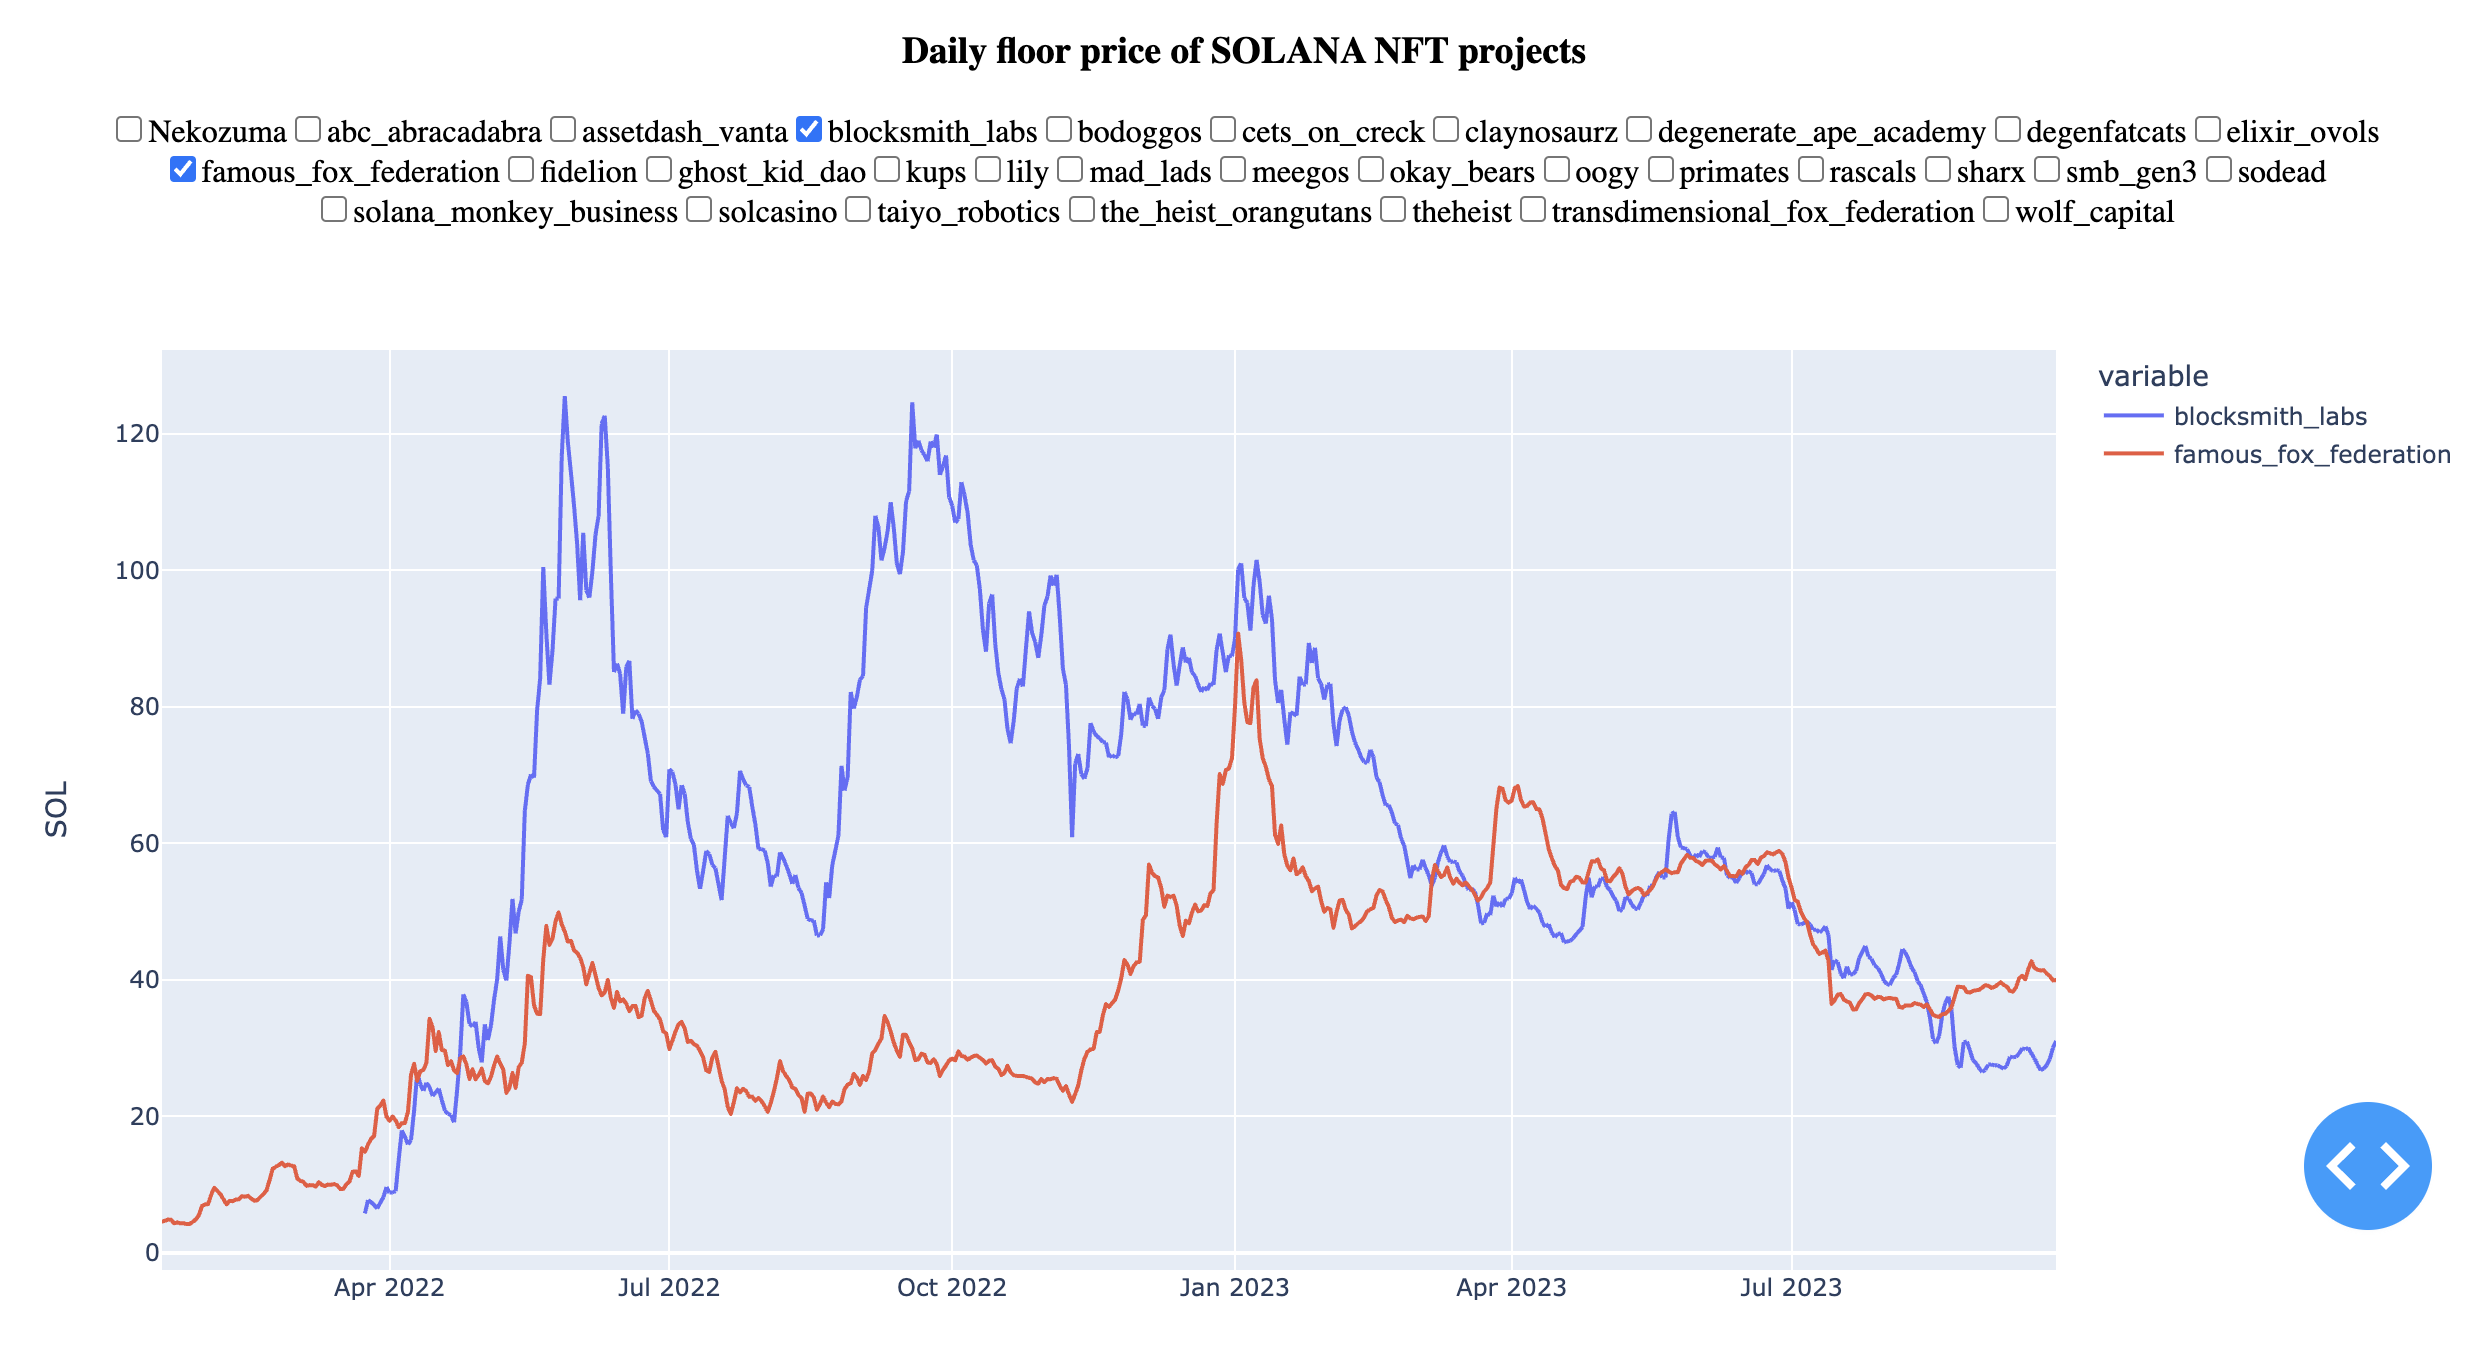

## Percentage change in price since Day 1


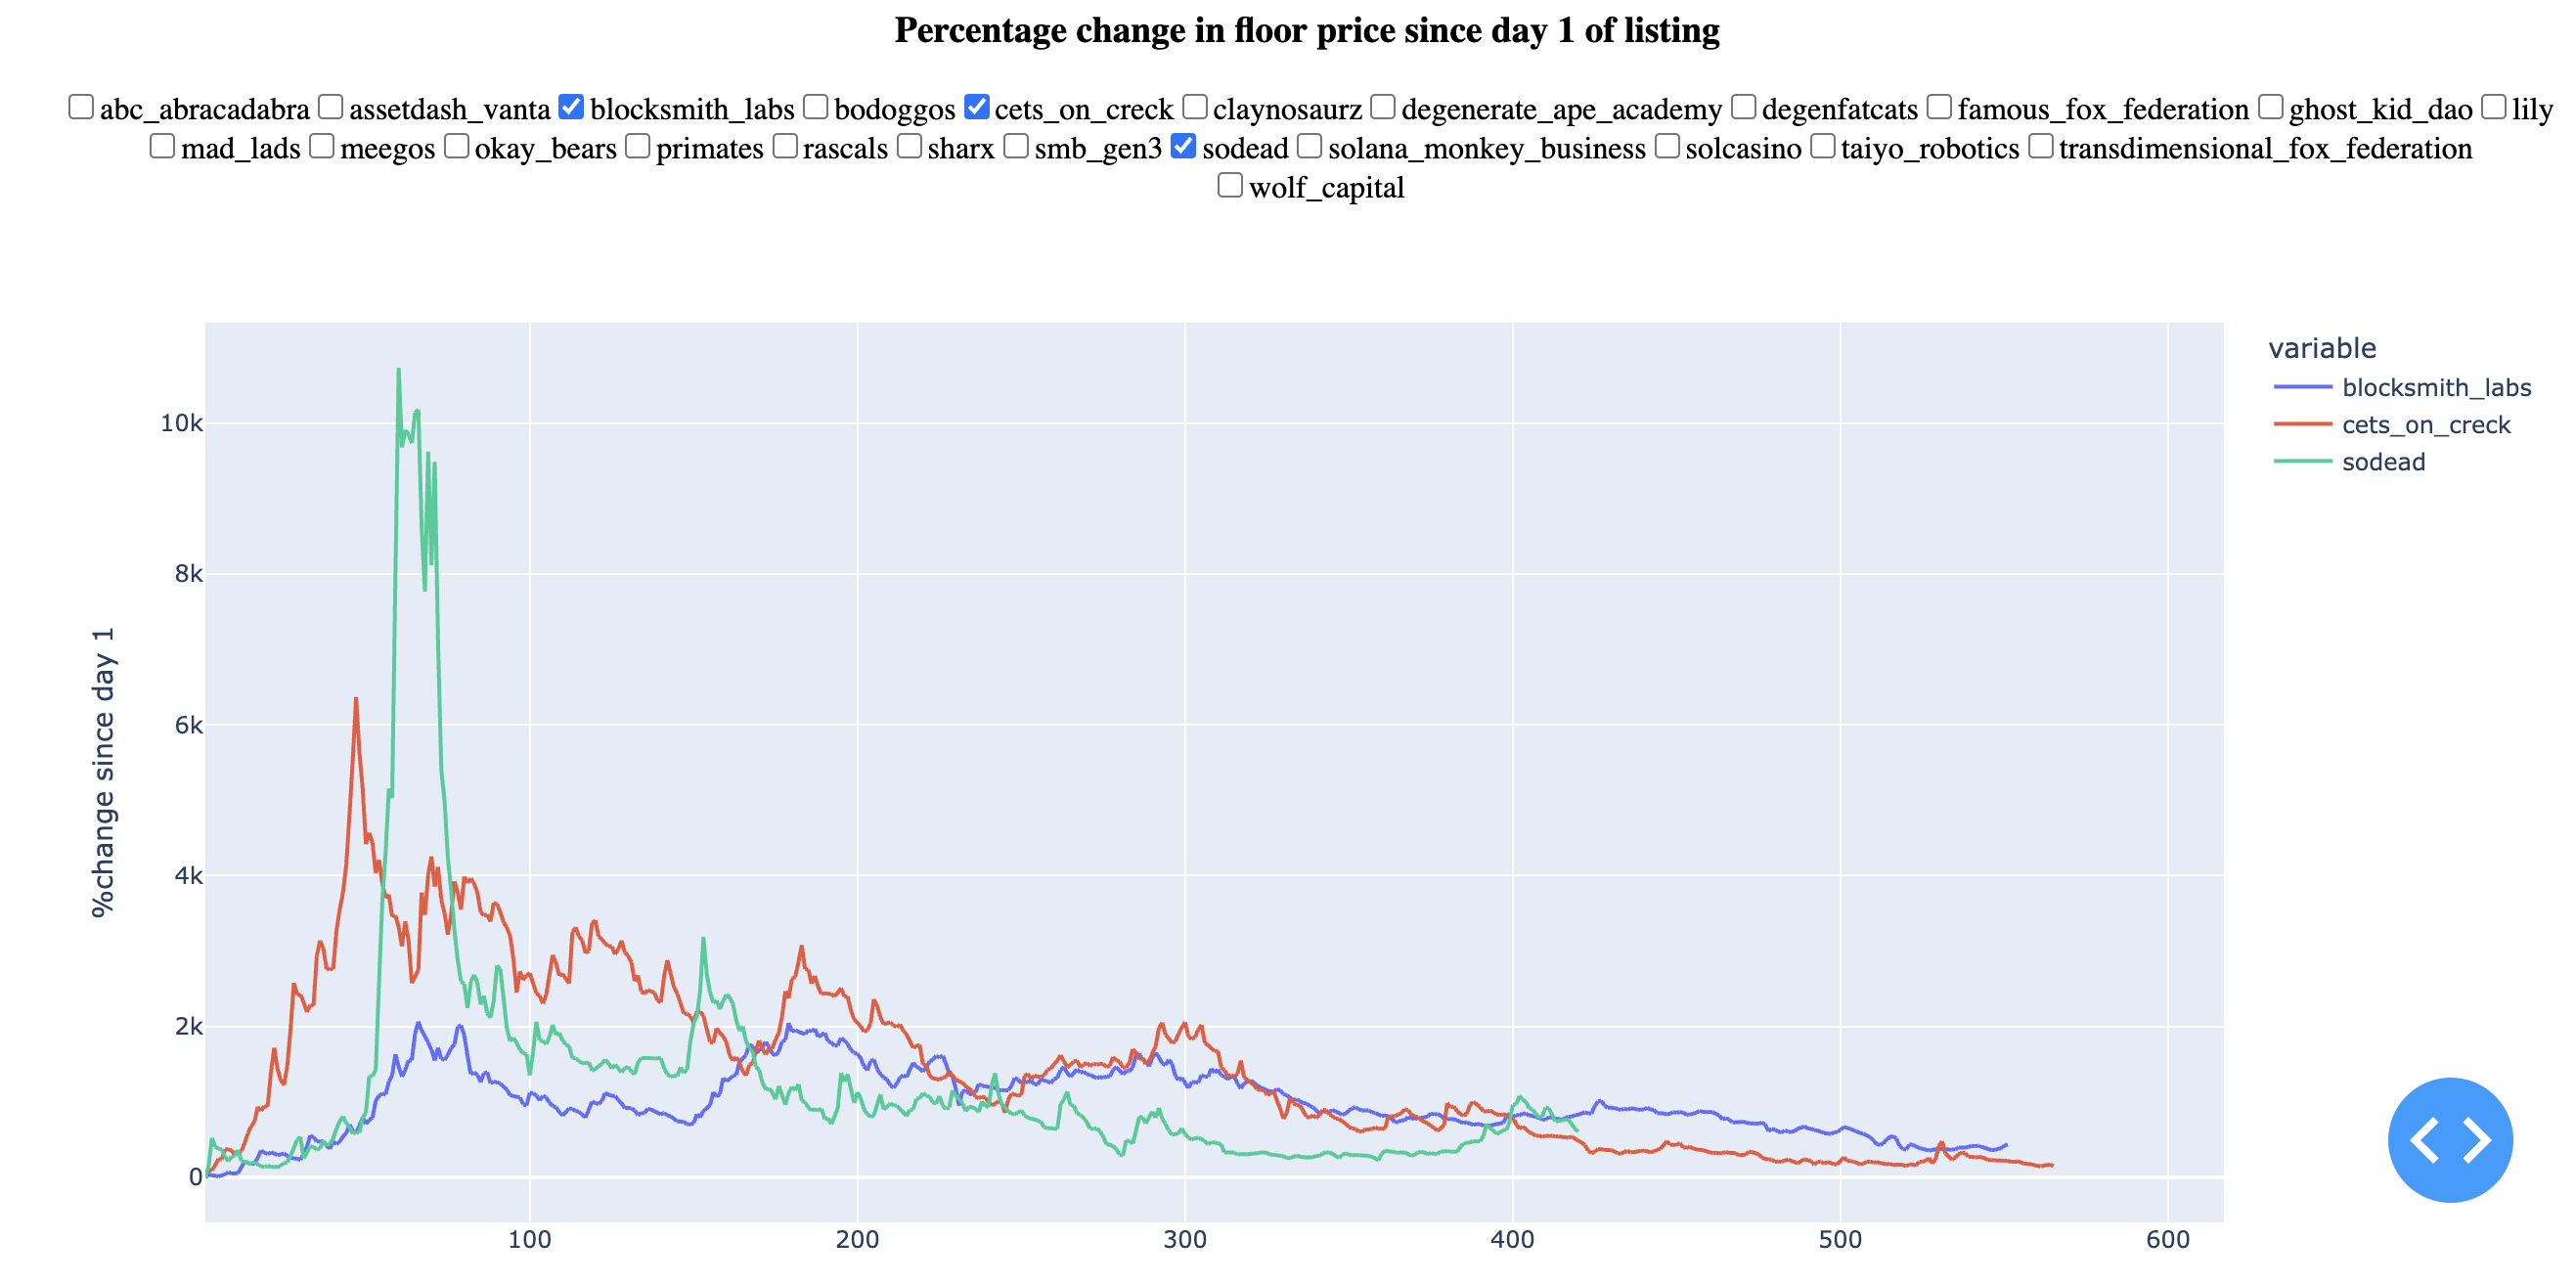

## Latest Unique Holder Percentages by Project


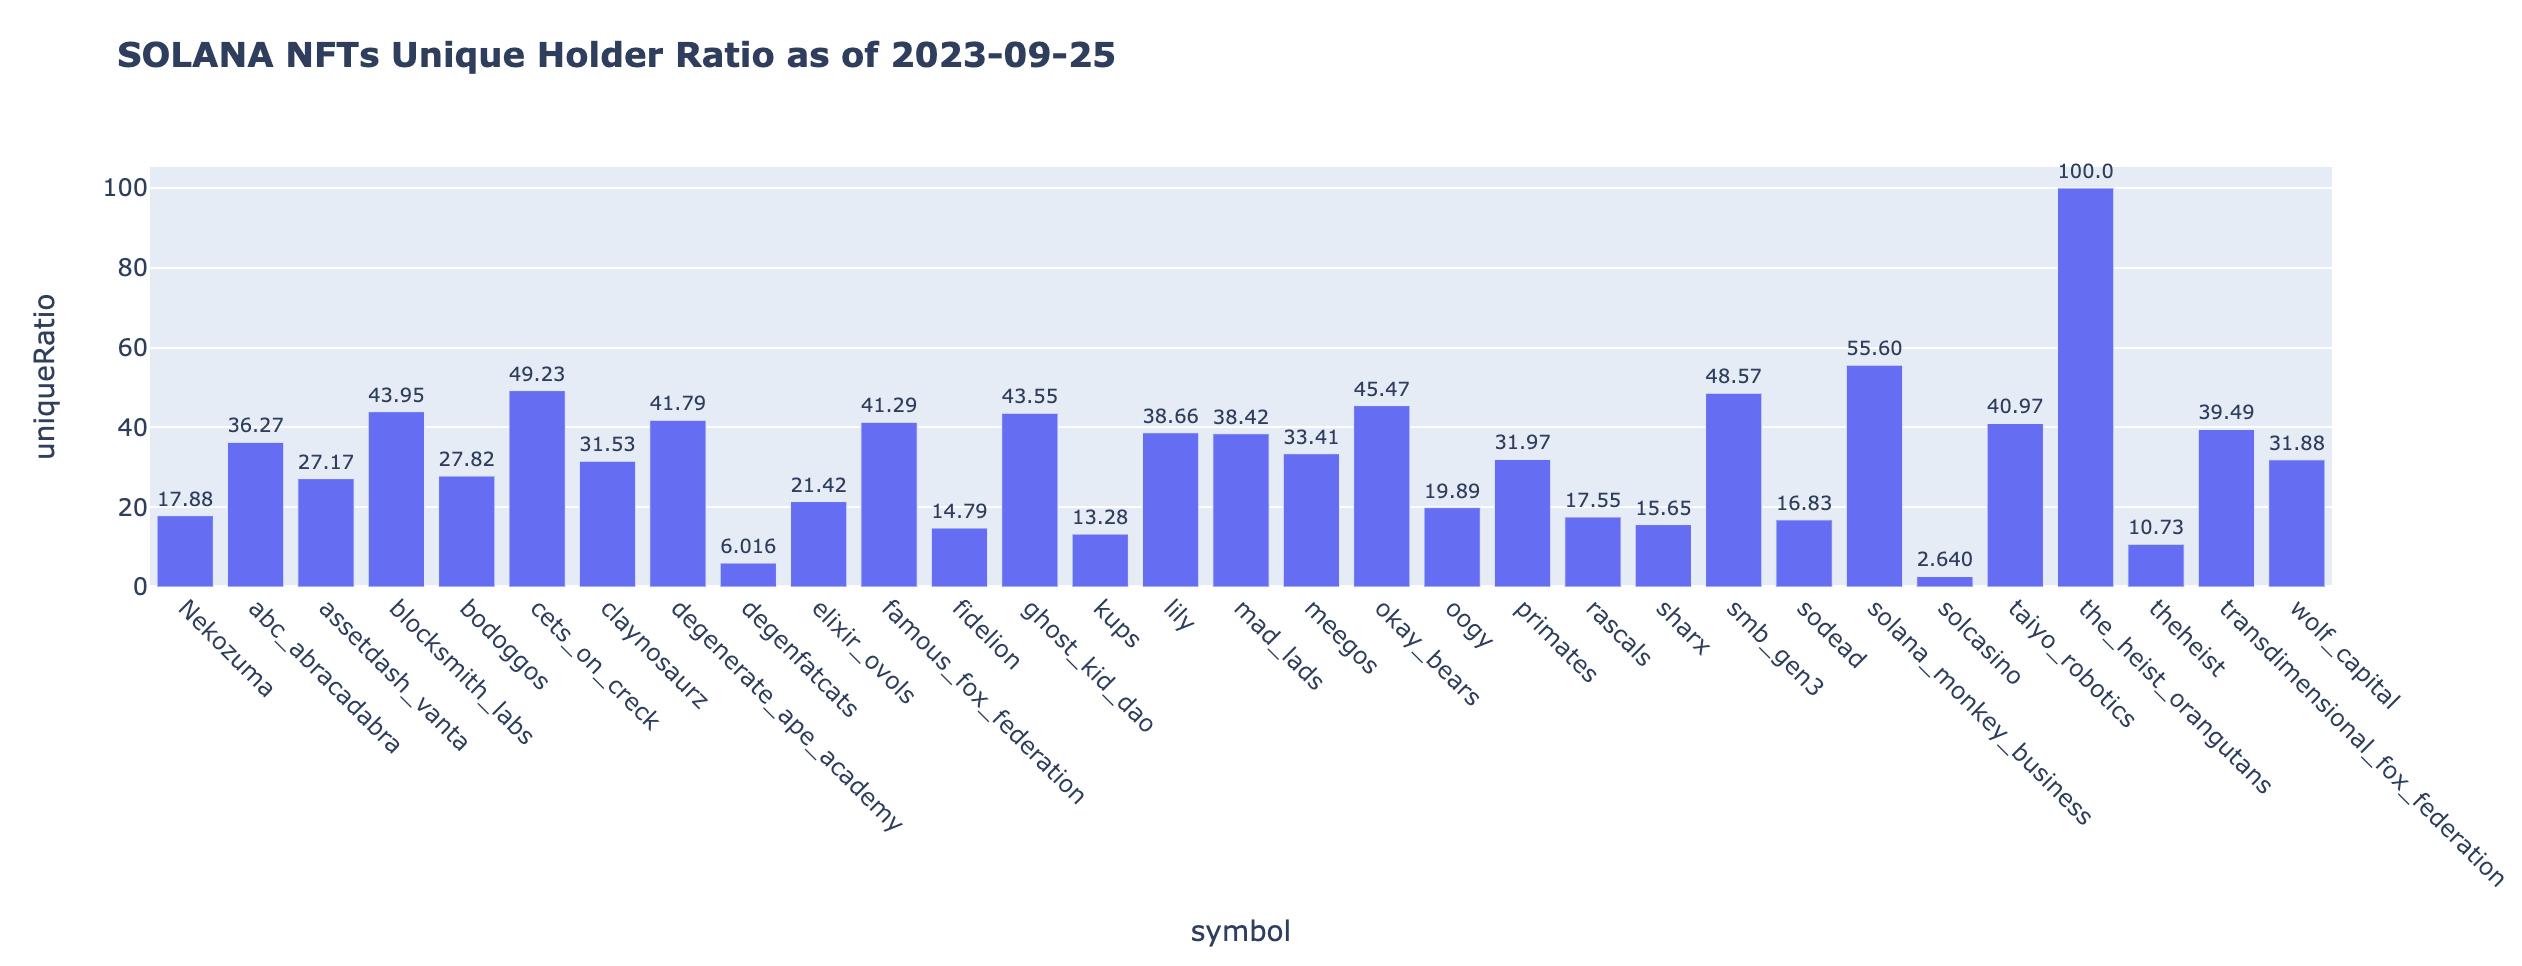

## Historical Unique Holder Percentages
*   Unfortunately, older data has been lost

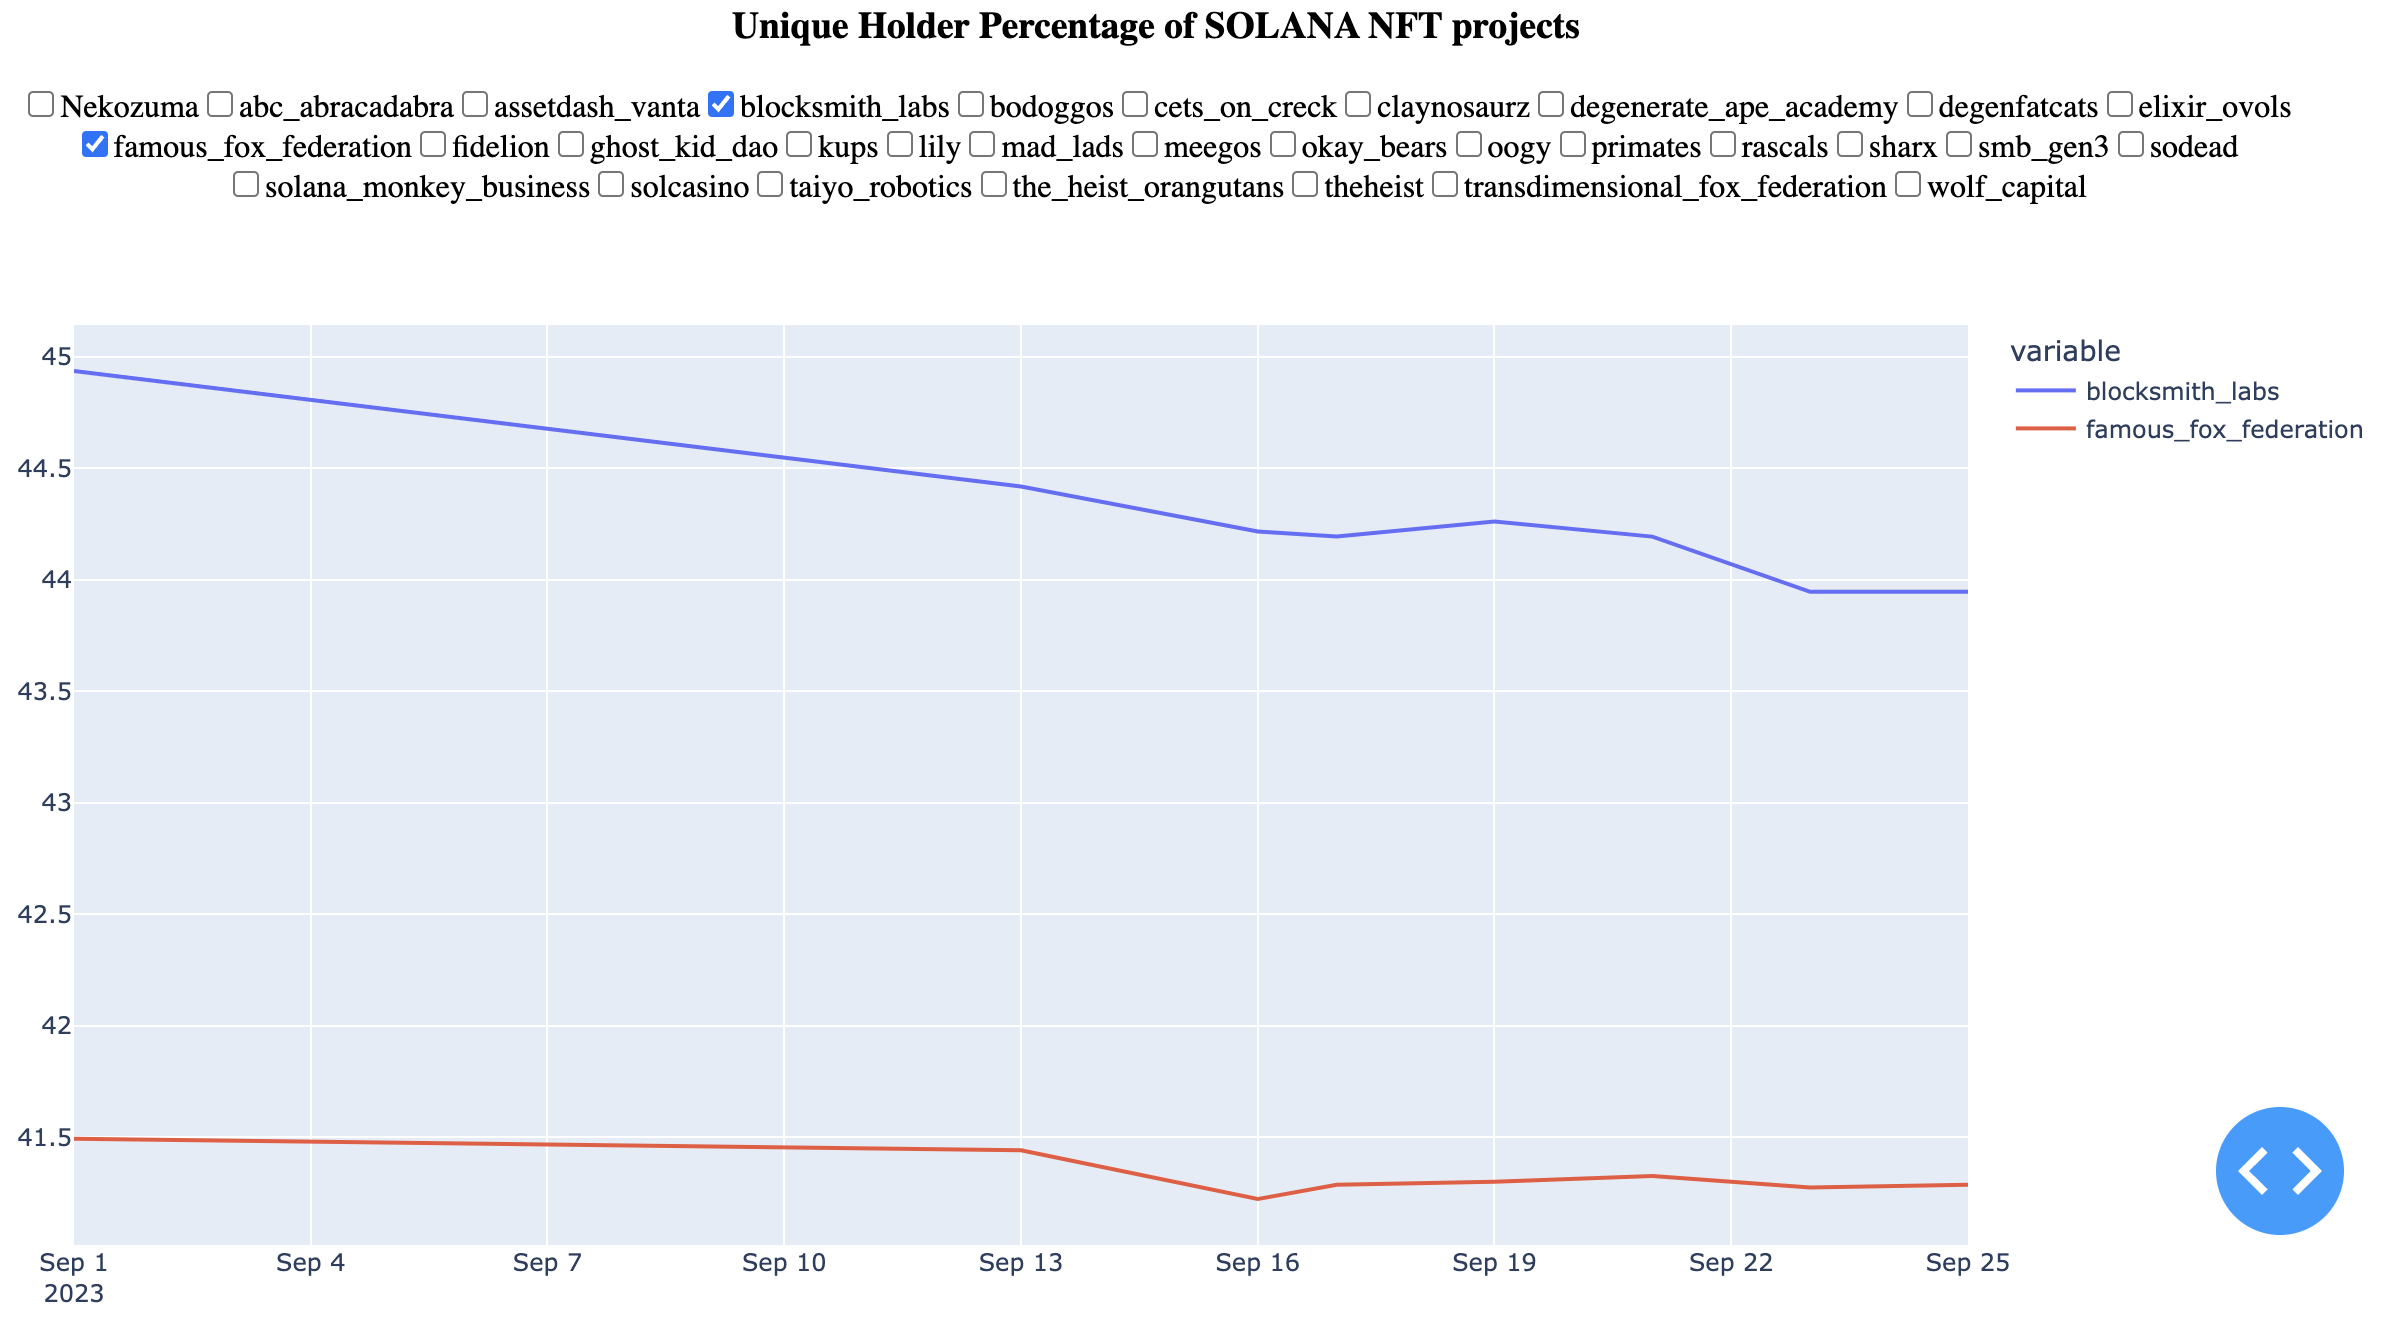